<div>
<img src="https://csdms.colorado.edu/csdms_wiki/images/ESPIn-mtns-skinny-transparent.png" width="800"/>
</div>

<div>
<img src="https://csdms.colorado.edu/csdms_wiki/images/thumb/CSDMS-logo-color-notagline-ver_high.png/400px-CSDMS-logo-color-notagline-ver_high.png" width="200" hspace="20"><a href="http://landlab.github.io"><img src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png" width="500"></a>
</div>

# Post-Glacial Landscape Lab: Exploring the Dynamic Environments of Glacial Retreat 
### Overview
This lab will introduce some of the key drivers of landscape change following deglaciation. The lab will also develop familiarity with modeling 2D systems via the Landlab modeling ecosystem, including setting up gridded topography with subsurface ice (RasterModelGrid), and employing physics-based landscape modification components (LinearDiffuser, OverlandFlow, LinearDiffusionOverlandFlowRouter, KinwaveImplicitOverlandFlow, FlowDirectorSteepest, SedDepEroder, NetworkSedimentTransporter). The final componant of the lab will be to simulate flow over real topography, obtained using Landlab Data Components.

### Time: 1-2 hrs

### Learning objectives
#### Skills
Running 2D numerical models to simulate short term landscape evolution applicable to rapidly warming Arctic and alpine Environments.

#### Key concepts

* Paraglacial processes
* Landlab
* CSDMS Data Component

### Requirements
If you don't already have a JupyterHub account, follow the instructions to sign up at https://csdms.colorado.edu/wiki/JupyterHub. If you're an educator, you can get JupyterHub accounts for students--please contact us through the CSDMS Help Desk: https://csdms.github.io/help-desk.
If run locally, please Please first download all the files from this repository and have conda installed on the local PC. Then, use the following commands to create a virtual environment and launch the Jupyter Notebook.

    $ cd 2025-postglacial-landscapes
    $ conda env create --file=environment.yml
    $ conda activate 2025-postglacial-landscapes
    $ jupyter notebook


### Contributors 
* Viet M Bui (organic rice fed - Delta & SLR dude)
* Ari Koeppel (sol3ling)
* Shayla Triantafillou (river gal)
* Karin Lehnigk (glof club)
* Lucille Baker-Stahl (temperature + morphodynamics = ?)
* Tom Hoseason (tbd)

This lab was developed as part of the 2025 Earth Surface Processeses Institute (ESPIn) with support from the National Science Foundation under collaborative grants 1831623, 2026951, 2140831, 2104102, and 2148762.

# Table of Contents
* [Introduction](#Introduction)
* [Setting up a Moraine Diffusion Model](#setting-up-a-moraine-diffusion-model)
* [Setting up an Overland Flow Model](#setting-up-an-overland-flow-model)
* [Sediment Transport](#sediment-transport-coupling-diffusion-and-flow)
* [Vegetation and Erodibility](#vegetation-and-erodibility)
* [Combining the Elements](#combining-the-elements-into-a-scaled-model)
* [Summary and implications for our warming Arctic and alpine](#Summary)


## Introduction

Studying the dynamics of ice-cored moraines is essential for understanding how postglacial landscapes evolve. These landforms trap and slowly release glacial ice beneath a cover of sediment, which affects rates of meltwater production and sediment transport. As ice cores degrade, they can generate localized subsidence, alter drainage patterns, and increase sediment input into downstream channels. By measuring changes in surface morphology, ice volume, and melt rates, researchers can quantify sediment budgets and model the long-term development of glacial forefields, improving predictions of landscape adjustment following glacier retreat. 

Beyond landscape evolution, ice-cored moraine dynamics pose direct implications for hazard assessment and water resources. Rapid collapse of moraine ridges or sudden outbursts of trapped meltwater may trigger debris flows, floods, and infrastructure damage in downstream communities. Conversely, the slow release of water from buried ice contributes to seasonal streamflow, particularly in regions dependent on glacial melt for irrigation and hydropower. Detailed monitoring and numerical modeling of ice-cored moraines thus support both risk mitigation—through early warning of potential slope failures—and resource management under changing climate conditions. 

In [1]:
# packages for the model
from landlab.components import LinearDiffuser, OverlandFlow, FlowDirectorSteepest, FlowAccumulator, SedDepEroder
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm

## Setting up a Moraine Diffusion Model

In [2]:
#define the grid
size_x = 100
size_y = 200
spacing = 1.0
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)

# morph the grid with a sine function
ice_height = 10
bedrock_slope = 0.22
soil_thickness = 5
moraine_disappears_at_y = 100

In [3]:
# add the topography    
z_ice = grid.add_zeros('ice_thickness', at='node')
z_soil = grid.add_zeros('soil_thickness', at='node')
z_bed = grid.add_zeros('bedrock_thickness', at='node')
elev = grid.add_zeros('topographic__elevation', at='node')

### Creating Hypothesis Moraine topography
z here is representing the shape of the ice core of moraine

In [4]:
x = grid.x_of_node
y = grid.y_of_node

# setting ice elevation respected to the base elevation
z = ice_height * np.sin(np.pi*x / (size_x/3)) 
# get z where y is less than moraine_disappears_at_y
z[y<moraine_disappears_at_y] += (y[y<moraine_disappears_at_y] - moraine_disappears_at_y) * ice_height/moraine_disappears_at_y
z[z<0] = 0 # cut the sine function at 0

Now assigning the z elevation into appropriate grid layers

In [5]:
z_ice += z
z_soil += soil_thickness
z_bed += bedrock_slope * y
elev = z_ice + z_soil + z_bed

In [6]:
# add boundaries
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_CLOSED
# grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED

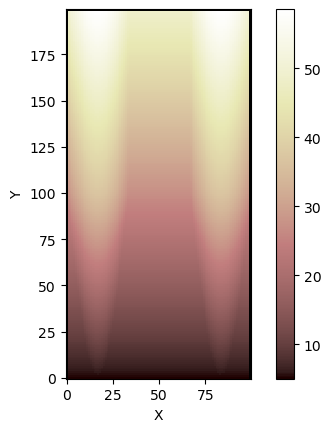

In [7]:
grid.imshow(elev)

### Visualization of each layer

Because all layers are added up into the paramater `elev`, what are showing bellow are each individual layer in 3D plot as standing alone layer.

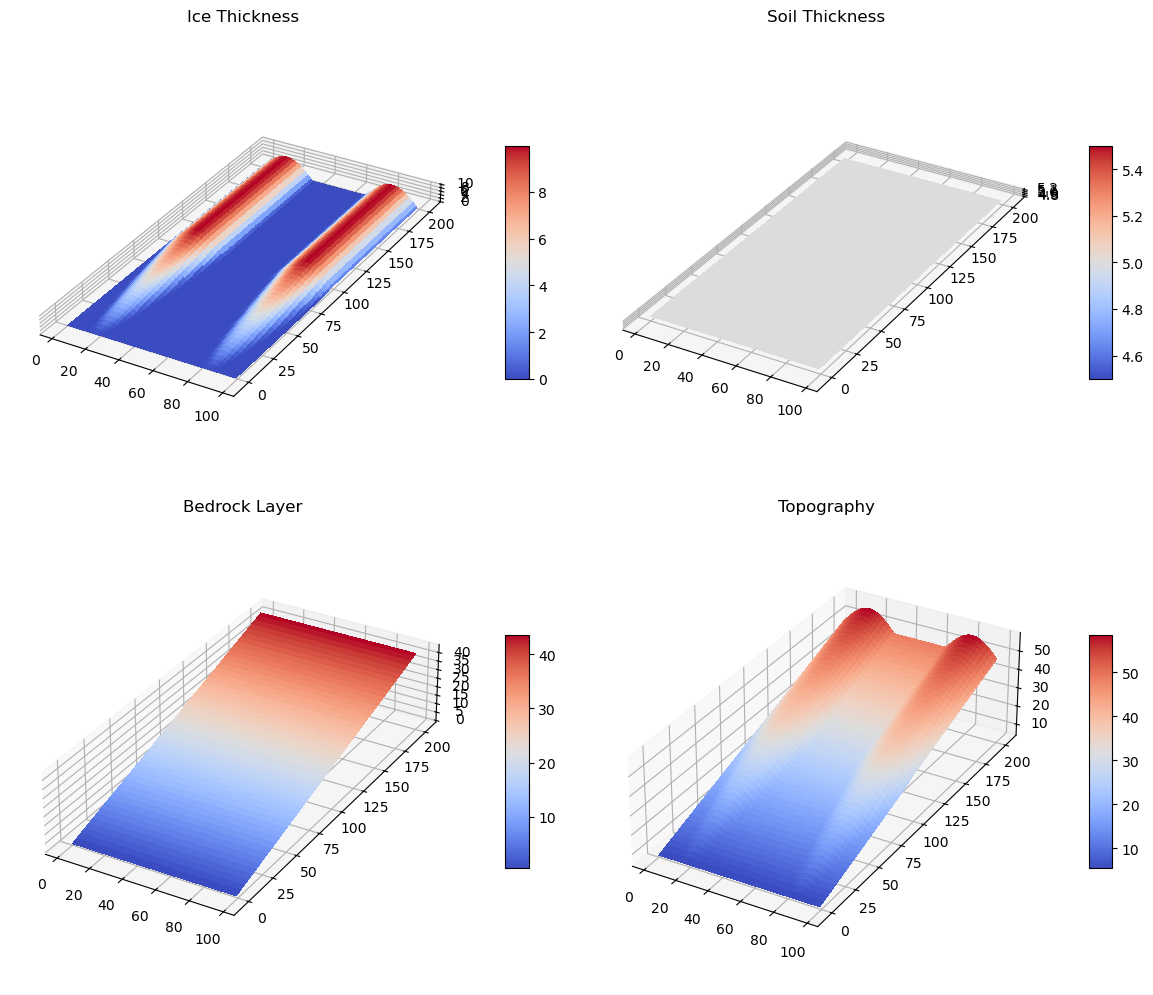

In [8]:
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 10))

def plot_each_axs(axs,size_x,size_y,topo, title="Topography"):
    X, Y = np.meshgrid(np.arange(0,size_x,spacing),np.arange(0,size_y,spacing))
    Z = topo.reshape(size_y, size_x)
    axs.set_box_aspect((1, size_y/size_x, Z.max()/size_x))
    axs.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs.set_title(title)
    cbar = fig.colorbar(axs.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False), ax=axs, shrink=0.5, aspect=10)

# Plot Ice Thickness
plot_each_axs(axs[0, 0], size_x, size_y, z_ice, title="Ice Thickness")

# Plot Soil Thickness
plot_each_axs(axs[0, 1], size_x, size_y, z_soil, title="Soil Thickness")

# Plot Bedrock Layer
plot_each_axs(axs[1, 0], size_x, size_y, z_bed, title="Bedrock Layer")

# Plot Topography
plot_each_axs(axs[1, 1], size_x, size_y, elev, title="Topography")

# Adjust layout
plt.tight_layout()
plt.show()

## Setting up an Overland Flow Model

Newly exposed surfaces in proglacial basins often experience overland flow as well-defined channels have yet to form.

## Sediment Transport: Coupling Diffusion and Flow

In [9]:
import matplotlib.pyplot as plt  # For plotting results; optional
import numpy as np

from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid  # For plotting results; optional
from landlab.components import Space  # SPACE model

from landlab.components import LinearDiffuser, OverlandFlow, FlowDirectorSteepest, FlowAccumulator, SedDepEroder, ChannelProfiler, PriorityFloodFlowRouter, DepressionFinderAndRouter
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
import matplotlib.cm as cm

In [10]:
# ChannelProfiler parameters
number_of_watersheds = 1
minimum_channel_threshold=100
# PriorityFloodFLowRouter parameters
flow_metric = "D8"
phi_FR = 0.0

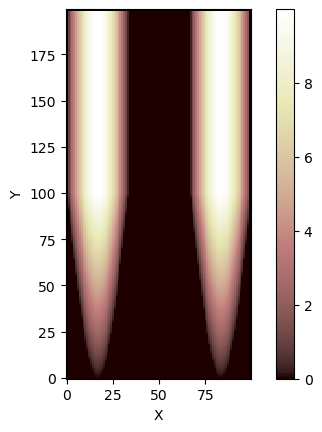

In [11]:
# Add field "soil__depth" to the grid
grid.add_zeros("soil__depth", at="node", dtype = "float")
# Set 2 m of initial soil depth at core nodes
grid.at_node["soil__depth"] += 8  # meters

# Add field 'bedrock__elevation' to the grid
# grid.add_zeros("bedrock__elevation", at="node")

import random
z_ice = grid.add_ones("bedrock__elevation", at="node")
z_ice *= np.sin(np.pi*x / (size_x/3))

# set constant random seed for consistent topographic roughness
np.random.seed(seed=5000)

# impose topography values on model grid
grid["node"]["topographic__elevation"]+= np.random.uniform(low = 0, high = 2, size = z.shape) 

grid.imshow(z)

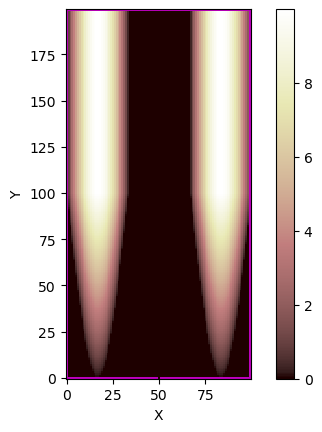

In [12]:
# Set boundaries closed at left, right, and top and visualize
# track sediment flux at the node adjacent to the outlet at lower-left
node_next_to_outlet = 51

grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=False, left_is_closed=True, right_is_closed=True, top_is_closed=True
)

# Set lower-edge as an open boundary
grid.set_watershed_boundary_condition_outlet_id(
    50 , grid["node"]["topographic__elevation"], -9999.0
)

grid.imshow(z, color_for_closed = 'm')

In [13]:
# Instantiate flow router
#fr = FlowAccumulator(grid, flow_director="FlowDirectorD8")

# Flow routing
fr = PriorityFloodFlowRouter(
	grid,
	surface = "topographic__elevation",
	flow_metric = flow_metric,
	depression_handler = "fill",
	accumulate_flow = True,
	separate_hill_flow = True,
	accumulate_flow_hill = True,
	)

# Instantiate depression finder and router; optional
df = DepressionFinderAndRouter(grid)

# Instantiate SPACE model with chosen parameters
sp = Space(
    grid,
    K_sed=0.01, # Sediment erodibility, Governs the rate of sediment entrainment; may be specified as a single floating point number, an array of length equal to the number of grid nodes, or a string naming an existing grid field.
    K_br=0.00001, # Bedrock erodibility, Governs the rate of bedrock erosion; may be specified as a single floating point number, an array of length equal to the number of grid nodes, or a string naming an existing grid field.
    F_f=0.0, # Fraction of fine sediment, (unitless, 0-1) fraction of rock that does not get converted to sediment but assumed to exit model domain as wash load
    phi=0.0, # Sediment porosity
    H_star=1.0, # Sediment entrainment length scale - think of reflecting bedrock surface roughness
    v_s=5.0, # Effective settling velocity
    m_sp=0.5, # Stream power exponent on drainage area or discharge in the stream power framework. Generally 0.5
    n_sp=1.0, # Stream power exponent n  on channel slope around 1
    sp_crit_sed=0, 
    sp_crit_br=0,
)

In [14]:
# Set model timestep
timestep = 50  # years

# Set elapsed time to zero
elapsed_time = 0.0  # years

# Set timestep count to zero
count = 0

# Set model run time
run_time = 500  # years

# Array to save sediment flux values
sed_flux = np.zeros(int(run_time // timestep))

while elapsed_time < run_time:  # time units of years
    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Save sediment flux value to array
    sed_flux[count] = grid.at_node["sediment__flux"][node_next_to_outlet]

    # Add to value of elapsed time
    elapsed_time += timestep

    # Increase timestep count
    count += 1

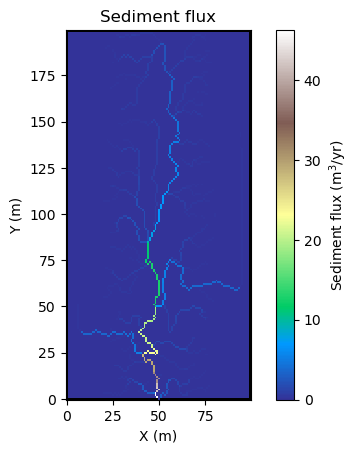

In [15]:
# Instantiate figure
fig = plt.figure()

# Instantiate subplot
plot = plt.subplot()

# Show sediment flux map
imshow_grid(
    grid,
    "sediment__flux",
    plot_name="Sediment flux",
    var_name="Sediment flux",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)

(0.0, 16.642887433346015)

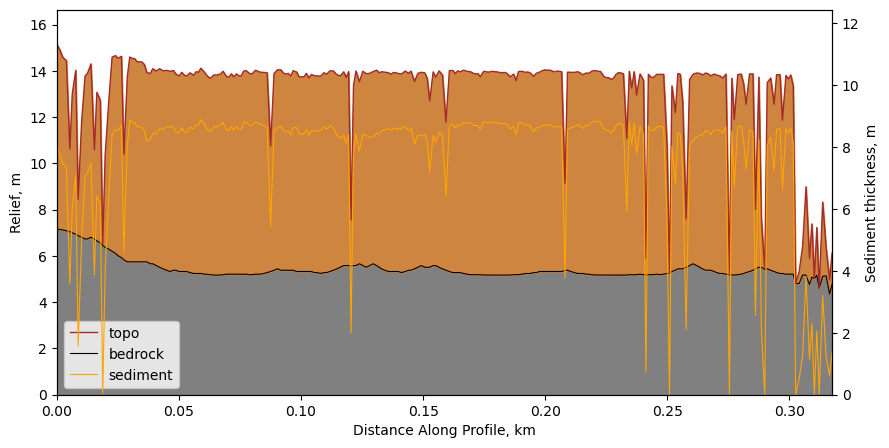

In [16]:
# channel deposition figure etc.
# Profiles with sediment
profiler = ChannelProfiler(grid)
profiler.run_one_step()
fig, ax1 = plt.subplots(figsize=(10,5))
riv_nodes = profiler.nodes
grid.at_node["bedrock_elevation"]=grid.at_node["topographic__elevation"]-grid.at_node["soil__depth"]
 
dist_atNodes=profiler.distance_along_profile[0]
el = grid.at_node["topographic__elevation"][riv_nodes]
sd = grid.at_node["soil__depth"][riv_nodes]
br = el- sd

 # Use ravel() to flatten el and br to 1D
el = el.ravel()
sd = sd.ravel()
br = br.ravel()
 
 # Calculate minimum elevation and relief
min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation
 
qs = grid.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nan
 
plt_fontsize =10
 
#fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()
dist = (max(dist_atNodes)-dist_atNodes)*1e-3
 
brown_c = [205/255,133/255,63/255]
 
# Fill the entire area from max relief to 0
#ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area')
 
# Fill the bedrtock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material')        
 
 # Plot bedrock and topographic relief
lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4)
 
 # set up labels
ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=plt_fontsize)
ax1.tick_params(labelsize=plt_fontsize)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=plt_fontsize)
ax1.set_ylim((0, np.max(el_relief)*1.1))
 
 # plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)
ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=plt_fontsize)
ax2.set_ylim((0, np.nanmax(sd) * 1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=plt_fontsize)
 
 # Merge legends
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=plt_fontsize)

# Set y-axis to start from 0
ax1.set_ylim(bottom=0)

## Vegetation and Erodibility

## Combining the Elements into a Scaled Model

In [ ]:
from landlab.components import LinearDiffuser, OverlandFlow, FlowDirectorSteepest, FlowAccumulator, SedDepEroder
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid

# Create a grid
# grid = RasterModelGrid((50, 50), xy_spacing=10.0)
# z = grid.add_zeros('topographic__elevation', at='node')
# z += np.random.rand(len(z)) * 0.1  # Add some random noise to the elevation

# Add subsurface ice
ice = grid.add_zeros('ice__thickness', at='node')
ice[grid.core_nodes] = np.random.rand(len(grid.core_nodes)) * 2.0  # Random ice thickness

swd = grid.add_zeros('surface_water__depth', at='node')
swd[grid.core_nodes] = np.random.rand(len(grid.core_nodes)) * 0.1  # Initial surface water depth

# Initialize components
diffuser = LinearDiffuser(grid, linear_diffusivity=0.01)
overland_flow = OverlandFlow(grid)
flow_director = FlowDirectorSteepest(grid)
flow_accumulator = FlowAccumulator(grid)
sed_dep_eroder = SedDepEroder(grid, K_sp=0.01, m_sp=0.5, n_sp=1.0)

FieldError: Unable to add the field, 'ice__thickness', to the group, 'node', because a field with that name already exists in that group. Use `clobber=True` to replace the existing field. For example, grid.add_field('ice__thickness', at='node', clobber=True)

Text(0.5, 1.0, 'Final Topography')

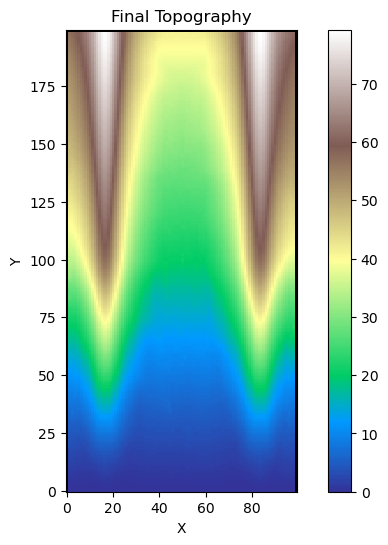

In [11]:
# Time loop
for t in range(100):  # Simulate 100 time steps
    # Simulate overland flow
    overland_flow.run_one_step()
    
    # Direct and accumulate flow
    flow_director.run_one_step()
    flow_accumulator.run_one_step()
    
    # Erode and deposit sediment
    sed_dep_eroder.run_one_step(dt=1.0)
    
    # Diffuse the landscape
    diffuser.run_one_step(dt=1.0)
    
    # Melt ice and adjust topography
    melt_rate = 0.01  # Example melt rate
    ice_melt = np.minimum(ice[grid.core_nodes], melt_rate)
    ice[grid.core_nodes] -= ice_melt
    z[grid.core_nodes] -= ice_melt

# Plot the final topography
plt.figure(figsize=(8, 6))
grid.imshow('topographic__elevation', cmap='terrain')
plt.title('Final Topography')
# plt.colorbar(label='Elevation (m)')
# plt.show()

## Summary

This document forms a simple basis, or starting point, for upscaling these results to a natural system in an arctic or alpine deglaciated valley.

### References

    Brook, M. S., & Paine, S. (2012). Ablation of ice‐cored moraine in a humid, maritime climate: Fox Glacier, New Zealand. Geografiska Annaler: Series A, Physical Geography, 94(3), 339-349.

    Church, M., & Ryder, J. M. (1972). Paraglacial sedimentation: a consideration of fluvial processes conditioned by glaciation. Geological Society of America Bulletin, 83(10), 3059-3072.
    
    Nicholson, L., & Benn, D. I. (2006). Calculating ice melt beneath a debris layer using meteorological data. Journal of Glaciology, 52(178), 463-470. https://doi.org/10.3189/172756506781828584

    Østrem, G. (1959). Ice melting under a thin layer of moraine, and the existence of ice cores in moraine ridges. Geografiska Annaler, 41(4), 228-230. https://www.jstor.org/stable/4626805

    Richardson, S. D., & Reynolds, J. M. (2000). Degradation of ice-cored moraine dams: implications for hazard development. IAHS PUBLICATION, 187-198.

    Schomacker, A., & Kjær, K. H. (2008). Quantification of dead‐ice melting in ice‐cored moraines at the high‐Arctic glacier Holmströmbreen, Svalbard. Boreas, 37(2), 211-225.

    Sletten, K., Lyså, A., & Lønne, I. (2001). Formation and disintegration of a high‐arctic ice‐cored moraine complex, Scott Turnerbreen, Svalbard. Boreas, 30(4), 272-284.https://doi.org/10.1111/j.1502-3885.2001.tb01046.x

    Westoby, M. J., Glasser, N. F., Brasington, J., Hambrey, M. J., Quincey, D. J., & Reynolds, J. M. (2014). Modelling outburst floods from moraine-dammed glacial lakes. Earth-Science Reviews, 134, 137-159. https://doi.org/10.1016/j.earscirev.2014.03.009